# 📊 07. Model Evaluation - Детальная оценка модели

**Цель:** Комплексная оценка качества тюнированной модели

**План:**
1. 📥 **Load Model** - загрузка модели
2. 📊 **Metrics** - все метрики
3. 🔄 **Cross-Validation** - кросс-валидация
4. 📈 **Learning Curves** - кривые обучения
5. 📉 **Residual Analysis** - анализ остатков
6. 🎯 **Prediction Analysis** - анализ предсказаний
7. 🔍 **Error Analysis** - где модель ошибается
8. 💾 **Final Report** - итоговый отчёт

---

In [1]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    mean_absolute_percentage_error, median_absolute_error, max_error
)
from scipy import stats
import joblib

# Настройки
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

RANDOM_STATE = 42

print('✅ Библиотеки загружены!')

✅ Библиотеки загружены!


---
# 1️⃣ LOAD MODEL & DATA

In [2]:
# Загрузка тюнированной модели
try:
    model = joblib.load('../models/xgboost_tuned.pkl')
    print('✅ Загружена тюнированная модель: xgboost_tuned.pkl')
except:
    print('⚠️ Тюнированная модель не найдена, загружаем обычную XGBoost')
    model = joblib.load('../models/xgboost.pkl')

# Загрузка данных
df = pd.read_csv('../data/processed/features_data.csv')

# Подготовка
target = 'price'
exclude_features = [
    'price', 'city', 'microdistrict', 'price_per_sqm',
    'room_type', 'area_category', 'building_height_category',
    'city_size', 'price_segment'
]

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_features if col not in exclude_features]

X = df[feature_cols].copy()
y = df[target].copy()

if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f'\n📊 Данные: {X_train.shape[0]:,} train, {X_test.shape[0]:,} test')
print(f'Признаков: {X.shape[1]}')

✅ Загружена тюнированная модель: xgboost_tuned.pkl

📊 Данные: 11,721 train, 2,931 test
Признаков: 31


---
# 2️⃣ COMPREHENSIVE METRICS

In [3]:
# Предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('='*70)
print('📊 COMPREHENSIVE METRICS')
print('='*70)

# Функция для всех метрик
def calculate_all_metrics(y_true, y_pred, dataset_name='Dataset'):
    metrics = {
        'Dataset': dataset_name,
        'R² Score': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'Median AE': median_absolute_error(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred),
        'Explained Var': 1 - np.var(y_true - y_pred) / np.var(y_true)
    }
    return metrics

# Метрики на Train и Test
metrics_train = calculate_all_metrics(y_train, y_pred_train, 'Train')
metrics_test = calculate_all_metrics(y_test, y_pred_test, 'Test')

metrics_df = pd.DataFrame([metrics_train, metrics_test])

print('\n')
print(metrics_df.to_string(index=False))

# Проверка переобучения
overfit_r2 = metrics_train['R² Score'] - metrics_test['R² Score']
print(f'\n⚠️ Разница R² (Train - Test): {overfit_r2:.4f}')
if overfit_r2 > 0.05:
    print('  → Есть переобучение')
elif overfit_r2 > 0.02:
    print('  → Небольшое переобучение')
else:
    print('  → Переобучения нет ✅')

📊 COMPREHENSIVE METRICS


Dataset  R² Score          RMSE          MAE  MAPE (%)  Median AE  Max Error  Explained Var
  Train  0.999986  39046.868248 27687.810547  0.166037    19616.0   466508.0       0.999986
   Test  0.999784 153286.433268 76849.992188  0.405200    39720.0  2662536.0       0.999784

⚠️ Разница R² (Train - Test): 0.0002
  → Переобучения нет ✅


---
# 3️⃣ CROSS-VALIDATION

In [4]:
print('='*70)
print('🔄 CROSS-VALIDATION (5-Fold)')
print('='*70)

# 5-fold CV
cv_scores_r2 = cross_val_score(
    model, X_train, y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

cv_scores_rmse = cross_val_score(
    model, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
cv_scores_rmse = np.sqrt(-cv_scores_rmse)

print(f'\n📊 R² Scores по фолдам:')
for i, score in enumerate(cv_scores_r2, 1):
    print(f'  Fold {i}: {score:.4f}')

print(f'\n📈 Статистика R²:')
print(f'  Среднее:  {cv_scores_r2.mean():.4f}')
print(f'  Медиана:  {np.median(cv_scores_r2):.4f}')
print(f'  Стд. откл.: {cv_scores_r2.std():.4f}')
print(f'  Минимум:  {cv_scores_r2.min():.4f}')
print(f'  Максимум: {cv_scores_r2.max():.4f}')

print(f'\n📊 RMSE по фолдам:')
for i, score in enumerate(cv_scores_rmse, 1):
    print(f'  Fold {i}: {score:,.0f} ₸')

print(f'\n📈 Статистика RMSE:')
print(f'  Среднее: {cv_scores_rmse.mean():,.0f} ₸')
print(f'  Стд. откл.: {cv_scores_rmse.std():,.0f} ₸')

# Стабильность модели
cv_stability = cv_scores_r2.std()
if cv_stability < 0.02:
    print(f'\n✅ Модель очень стабильная (std = {cv_stability:.4f})')
elif cv_stability < 0.05:
    print(f'\n✅ Модель стабильная (std = {cv_stability:.4f})')
else:
    print(f'\n⚠️ Модель нестабильная (std = {cv_stability:.4f})')

🔄 CROSS-VALIDATION (5-Fold)

📊 R² Scores по фолдам:
  Fold 1: 0.9997
  Fold 2: 0.9997
  Fold 3: 0.9997
  Fold 4: 0.9996
  Fold 5: 0.9997

📈 Статистика R²:
  Среднее:  0.9997
  Медиана:  0.9997
  Стд. откл.: 0.0000
  Минимум:  0.9996
  Максимум: 0.9997

📊 RMSE по фолдам:
  Fold 1: 192,836 ₸
  Fold 2: 163,154 ₸
  Fold 3: 164,065 ₸
  Fold 4: 195,866 ₸
  Fold 5: 167,544 ₸

📈 Статистика RMSE:
  Среднее: 176,693 ₸
  Стд. откл.: 14,524 ₸

✅ Модель очень стабильная (std = 0.0000)


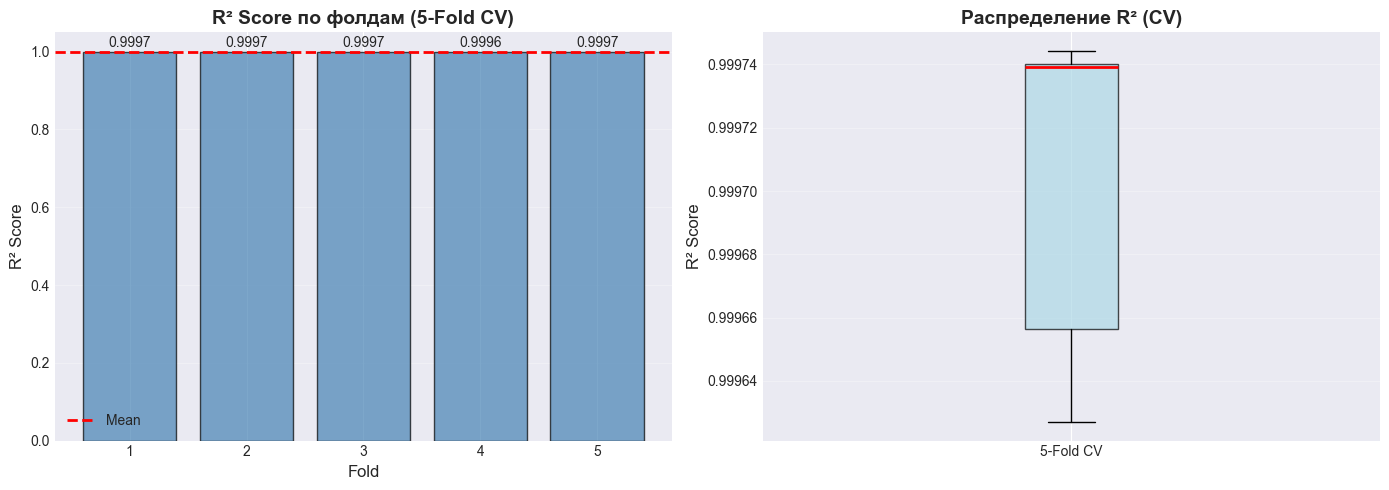

In [5]:
# Визуализация CV scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. R² по фолдам
axes[0].bar(range(1, 6), cv_scores_r2, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axhline(cv_scores_r2.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score по фолдам (5-Fold CV)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 6))
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for i, val in enumerate(cv_scores_r2, 1):
    axes[0].text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Box plot CV scores
axes[1].boxplot([cv_scores_r2], vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7),
               medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Распределение R² (CV)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['5-Fold CV'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 4️⃣ LEARNING CURVES

📈 LEARNING CURVES

🔄 Вычисляем learning curves (может занять время)...
✅ Learning curves готовы


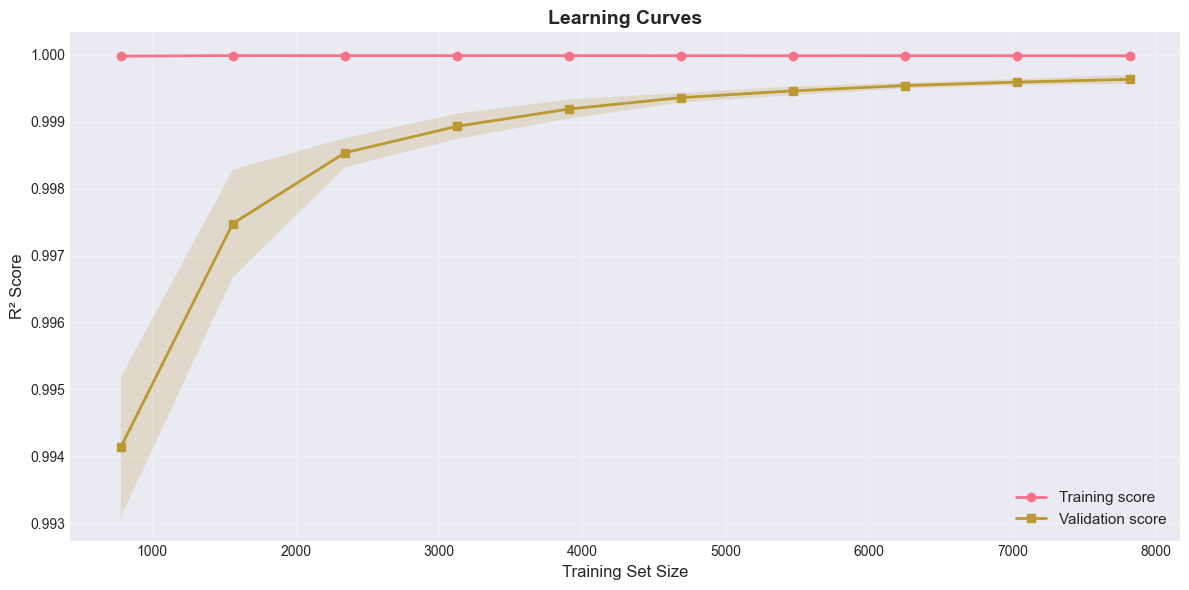


📊 Анализ Learning Curves:
  Train score (full): 1.0000
  Val score (full):   0.9996
  Gap:                0.0004
  ✅ Нет переобучения


In [6]:
print('='*70)
print('📈 LEARNING CURVES')
print('='*70)

# Строим learning curves
train_sizes = np.linspace(0.1, 1.0, 10)

print('\n🔄 Вычисляем learning curves (может занять время)...')

train_sizes_abs, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    train_sizes=train_sizes,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Средние и std
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

print('✅ Learning curves готовы')

# График
plt.figure(figsize=(12, 6))
plt.plot(train_sizes_abs, train_mean, label='Training score', marker='o', linewidth=2)
plt.fill_between(train_sizes_abs, train_mean - train_std,
                 train_mean + train_std, alpha=0.2)
plt.plot(train_sizes_abs, val_mean, label='Validation score', marker='s', linewidth=2)
plt.fill_between(train_sizes_abs, val_mean - val_std,
                 val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Learning Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Анализ
gap = train_mean[-1] - val_mean[-1]
print(f'\n📊 Анализ Learning Curves:')
print(f'  Train score (full): {train_mean[-1]:.4f}')
print(f'  Val score (full):   {val_mean[-1]:.4f}')
print(f'  Gap:                {gap:.4f}')

if gap < 0.02:
    print('  ✅ Нет переобучения')
elif gap < 0.05:
    print('  ⚠️ Небольшое переобучение')
else:
    print('  ❌ Переобучение присутствует')

if val_mean[-1] < val_mean[-2]:
    print('  💡 Возможно, стоит собрать больше данных')

---
# 5️⃣ RESIDUAL ANALYSIS

In [7]:
print('='*70)
print('📉 RESIDUAL ANALYSIS')
print('='*70)

# Residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

print(f'\n📊 Статистика остатков (Test):')
print(f'  Среднее:     {residuals_test.mean():>12,.0f} ₸')
print(f'  Медиана:     {residuals_test.median():>12,.0f} ₸')
print(f'  Стд. откл.:  {residuals_test.std():>12,.0f} ₸')
print(f'  Минимум:     {residuals_test.min():>12,.0f} ₸')
print(f'  Максимум:    {residuals_test.max():>12,.0f} ₸')
print(f'  IQR:         {residuals_test.quantile(0.75) - residuals_test.quantile(0.25):>12,.0f} ₸')

# Проверка предположений
print(f'\n🔍 Проверка предположений:')

# 1. Среднее близко к 0?
if abs(residuals_test.mean()) < residuals_test.std() * 0.1:
    print('  ✅ Среднее остатков ≈ 0')
else:
    print('  ⚠️ Среднее остатков != 0 (возможна систематическая ошибка)')

# 2. Нормальность
_, p_value = stats.shapiro(residuals_test.sample(min(5000, len(residuals_test)), random_state=42))
print(f'  Shapiro-Wilk p-value: {p_value:.6f}')
if p_value > 0.05:
    print('  ✅ Остатки распределены нормально')
else:
    print('  ⚠️ Остатки НЕ нормальные')

📉 RESIDUAL ANALYSIS

📊 Статистика остатков (Test):
  Среднее:            1,606 ₸
  Медиана:           -1,064 ₸
  Стд. откл.:       153,304 ₸
  Минимум:       -2,662,536 ₸
  Максимум:       2,021,928 ₸
  IQR:               79,512 ₸

🔍 Проверка предположений:
  ✅ Среднее остатков ≈ 0
  Shapiro-Wilk p-value: 0.000000
  ⚠️ Остатки НЕ нормальные


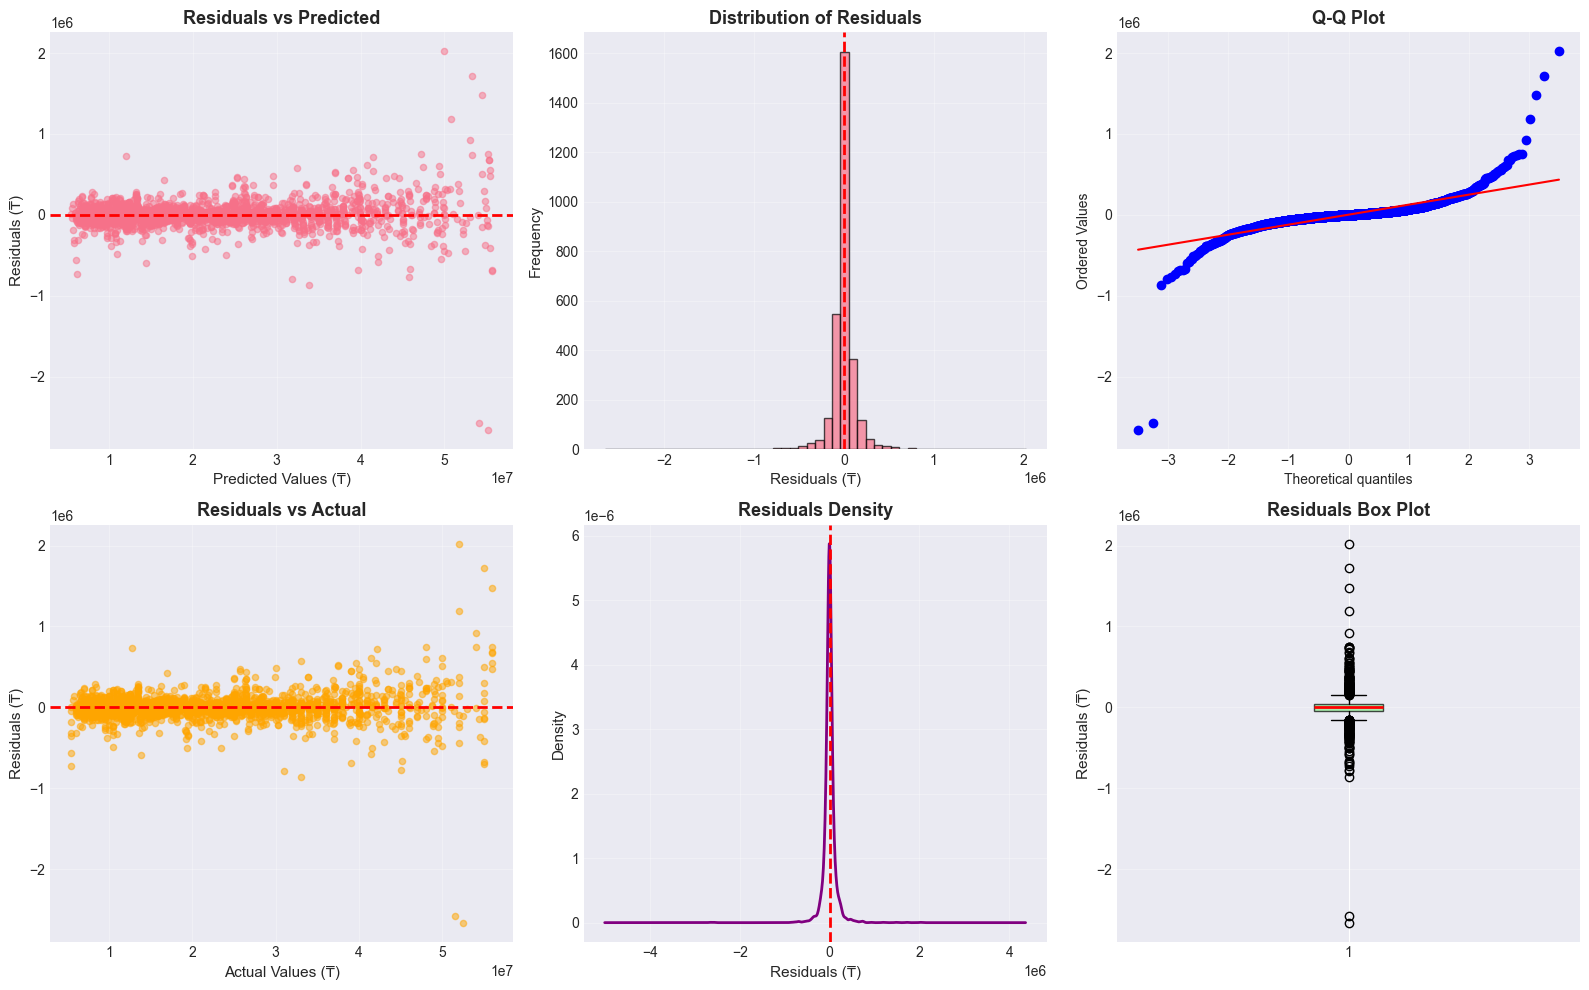

In [8]:
# Детальная визуализация остатков
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred_test, residuals_test, alpha=0.5, s=20)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values (₸)', fontsize=11)
axes[0, 0].set_ylabel('Residuals (₸)', fontsize=11)
axes[0, 0].set_title('Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram
axes[0, 1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (₸)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
stats.probplot(residuals_test, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot', fontsize=13, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals vs Actual
axes[1, 0].scatter(y_test, residuals_test, alpha=0.5, s=20, color='orange')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Actual Values (₸)', fontsize=11)
axes[1, 0].set_ylabel('Residuals (₸)', fontsize=11)
axes[1, 0].set_title('Residuals vs Actual', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. KDE
residuals_test.plot(kind='density', ax=axes[1, 1], color='purple', linewidth=2)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals (₸)', fontsize=11)
axes[1, 1].set_ylabel('Density', fontsize=11)
axes[1, 1].set_title('Residuals Density', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 6. Box Plot
axes[1, 2].boxplot([residuals_test], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightgreen', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[1, 2].set_ylabel('Residuals (₸)', fontsize=11)
axes[1, 2].set_title('Residuals Box Plot', fontsize=13, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/residual_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 6️⃣ PREDICTION ANALYSIS

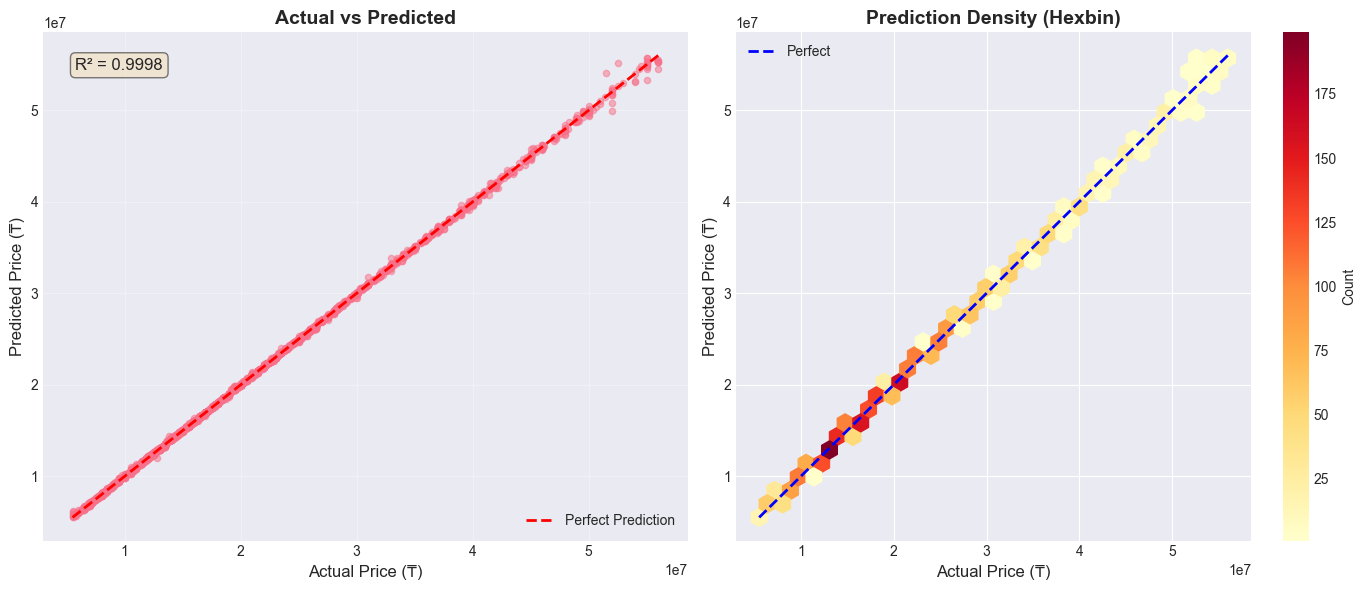

In [9]:
# Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Scatter plot
axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=20)
# Perfect prediction line
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (₸)', fontsize=12)
axes[0].set_ylabel('Predicted Price (₸)', fontsize=12)
axes[0].set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R² на графике
r2_test = r2_score(y_test, y_pred_test)
axes[0].text(0.05, 0.95, f'R² = {r2_test:.4f}',
            transform=axes[0].transAxes, fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Hexbin для плотности
hexbin = axes[1].hexbin(y_test, y_pred_test, gridsize=30, cmap='YlOrRd', mincnt=1)
axes[1].plot([min_val, max_val], [min_val, max_val], 'b--', linewidth=2, label='Perfect')
axes[1].set_xlabel('Actual Price (₸)', fontsize=12)
axes[1].set_ylabel('Predicted Price (₸)', fontsize=12)
axes[1].set_title('Prediction Density (Hexbin)', fontsize=14, fontweight='bold')
axes[1].legend()
plt.colorbar(hexbin, ax=axes[1], label='Count')

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

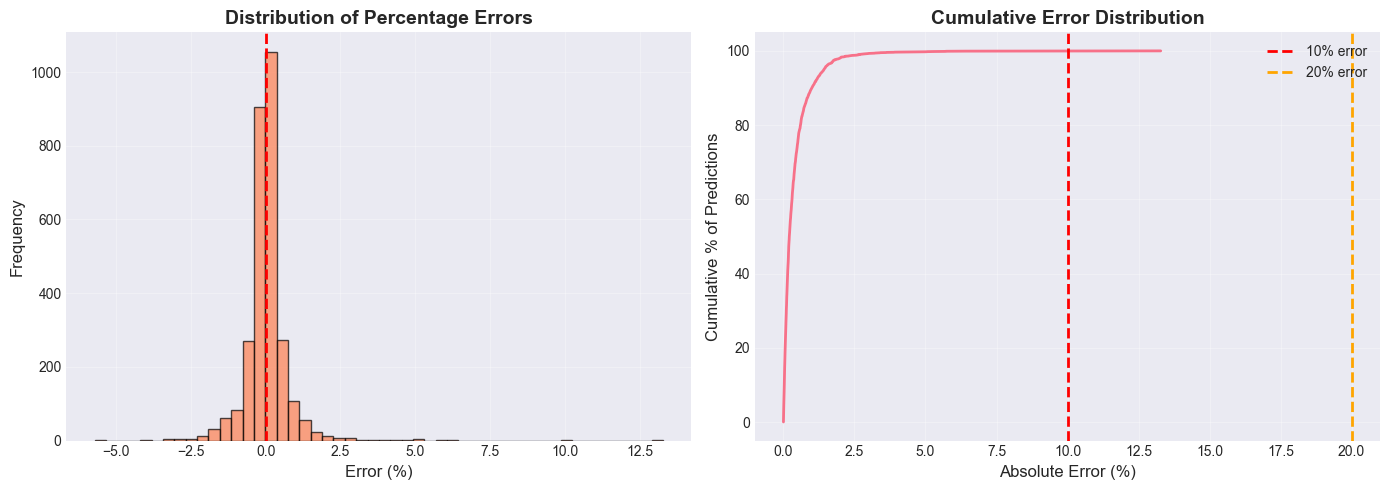


📊 Статистика ошибок (%):
  Среднее:         0.02%
  Медиана:         0.01%
  Стд. откл.:      0.74%

📈 Точность предсказаний:
  В пределах ±5%:  99.7%
  В пределах ±10%: 99.9%
  В пределах ±20%: 100.0%


In [10]:
# Error distribution
errors_pct = ((y_pred_test - y_test) / y_test) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Error percentage distribution
axes[0].hist(errors_pct, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Error (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Percentage Errors', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Cumulative error
sorted_errors = np.sort(np.abs(errors_pct))
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1].plot(sorted_errors, cumulative, linewidth=2)
axes[1].axvline(10, color='red', linestyle='--', linewidth=2, label='10% error')
axes[1].axvline(20, color='orange', linestyle='--', linewidth=2, label='20% error')
axes[1].set_xlabel('Absolute Error (%)', fontsize=12)
axes[1].set_ylabel('Cumulative % of Predictions', fontsize=12)
axes[1].set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Статистика ошибок
print('\n📊 Статистика ошибок (%):')
print(f'  Среднее:     {errors_pct.mean():>8.2f}%')
print(f'  Медиана:     {errors_pct.median():>8.2f}%')
print(f'  Стд. откл.:  {errors_pct.std():>8.2f}%')

# Процент предсказаний в пределах X%
within_5 = (np.abs(errors_pct) <= 5).sum() / len(errors_pct) * 100
within_10 = (np.abs(errors_pct) <= 10).sum() / len(errors_pct) * 100
within_20 = (np.abs(errors_pct) <= 20).sum() / len(errors_pct) * 100

print(f'\n📈 Точность предсказаний:')
print(f'  В пределах ±5%:  {within_5:.1f}%')
print(f'  В пределах ±10%: {within_10:.1f}%')
print(f'  В пределах ±20%: {within_20:.1f}%')

---
# 7️⃣ ERROR ANALYSIS - Где модель ошибается

In [11]:
print('='*70)
print('🔍 ERROR ANALYSIS - Где модель ошибается')
print('='*70)

# Создаём DataFrame с ошибками
error_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_test,
    'error': y_test - y_pred_test,
    'error_pct': ((y_pred_test - y_test) / y_test) * 100,
    'abs_error': np.abs(y_test - y_pred_test),
    'abs_error_pct': np.abs((y_pred_test - y_test) / y_test) * 100
})

# Добавляем признаки для анализа
error_analysis = pd.concat([error_analysis, X_test.reset_index(drop=True)], axis=1)

# Топ-10 худших предсказаний
worst_predictions = error_analysis.nlargest(10, 'abs_error')[[
    'actual', 'predicted', 'error', 'error_pct'
]]

print('\n🔴 Топ-10 худших предсказаний:')
print(worst_predictions.to_string(index=False))

🔍 ERROR ANALYSIS - Где модель ошибается

🔴 Топ-10 худших предсказаний:
    actual  predicted      error  error_pct
52500000.0 55162536.0 -2662536.0   5.071497
51489200.0 54067788.0 -2578588.0   5.008017
52000000.0 49978072.0  2021928.0  -3.888323
55000000.0 53281112.0  1718888.0  -3.125251
56000000.0 54521496.0  1478504.0  -2.640186
52000000.0 50811692.0  1188308.0  -2.285208
54000000.0 53078444.0   921556.0  -1.706585
33000000.0 33863296.0  -863296.0   2.616048
31000000.0 31792538.0  -792538.0   2.556574
45000000.0 45772928.0  -772928.0   1.717618



📊 Ошибки по ценовым сегментам:
                   abs_error  abs_error_pct  count
price_segment                                     
Low             73117.360776       0.763513    747
Medium-Low      41744.357527       0.261678    744
Medium-High     54399.246110       0.238027    707
High           137940.768076       0.346964    733


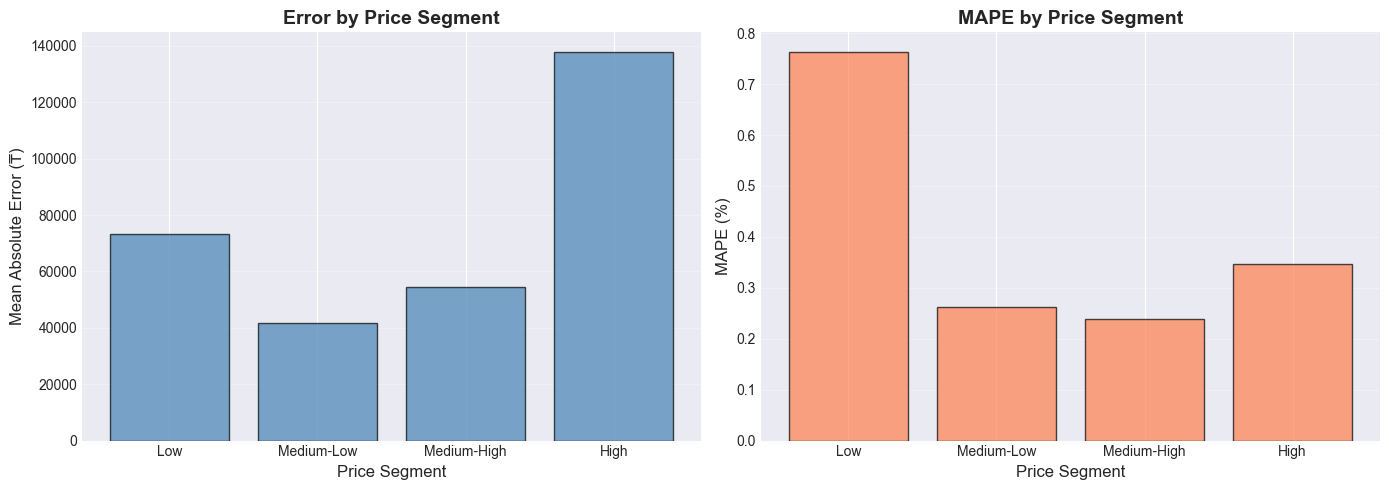

In [12]:
# Анализ ошибок по ценовым сегментам
error_analysis['price_segment'] = pd.qcut(error_analysis['actual'], 
                                           q=4, 
                                           labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

segment_errors = error_analysis.groupby('price_segment').agg({
    'abs_error': 'mean',
    'abs_error_pct': 'mean',
    'actual': 'count'
}).rename(columns={'actual': 'count'})

print('\n📊 Ошибки по ценовым сегментам:')
print(segment_errors)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Mean absolute error по сегментам
axes[0].bar(range(len(segment_errors)), segment_errors['abs_error'].values,
           color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(segment_errors)))
axes[0].set_xticklabels(segment_errors.index)
axes[0].set_xlabel('Price Segment', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (₸)', fontsize=12)
axes[0].set_title('Error by Price Segment', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. MAPE по сегментам
axes[1].bar(range(len(segment_errors)), segment_errors['abs_error_pct'].values,
           color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(segment_errors)))
axes[1].set_xticklabels(segment_errors.index)
axes[1].set_xlabel('Price Segment', fontsize=12)
axes[1].set_ylabel('MAPE (%)', fontsize=12)
axes[1].set_title('MAPE by Price Segment', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/model_evaluation/error_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()

---
# 8️⃣ SAVE EVALUATION REPORT

In [13]:
# Создаём финальный отчёт
final_report = {
    'Model': 'XGBoost (Tuned)',
    'Test R²': r2_score(y_test, y_pred_test),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'Test MAE': mean_absolute_error(y_test, y_pred_test),
    'Test MAPE': mean_absolute_percentage_error(y_test, y_pred_test) * 100,
    'CV R² Mean': cv_scores_r2.mean(),
    'CV R² Std': cv_scores_r2.std(),
    'Within ±10%': within_10,
    'Within ±20%': within_20,
    'Train Samples': len(X_train),
    'Test Samples': len(X_test),
    'Features': X.shape[1]
}

report_df = pd.DataFrame([final_report]).T
report_df.columns = ['Value']

print('='*70)
print('📄 FINAL EVALUATION REPORT')
print('='*70)
print('\n')
print(report_df)

# Сохраняем
report_df.to_csv('../reports/tables/model_evaluation_report.csv')
print('\n✅ Отчёт сохранён: reports/tables/model_evaluation_report.csv')

📄 FINAL EVALUATION REPORT


                         Value
Model          XGBoost (Tuned)
Test R²               0.999784
Test RMSE        153286.433268
Test MAE          76849.992188
Test MAPE               0.4052
CV R² Mean            0.999701
CV R² Std              0.00005
Within ±10%          99.931764
Within ±20%              100.0
Train Samples            11721
Test Samples              2931
Features                    31

✅ Отчёт сохранён: reports/tables/model_evaluation_report.csv


---
## ✅ ИТОГИ MODEL EVALUATION

### Метрики:
- **R² Score:** *(см. выше)*
- **RMSE:** *(см. выше)*
- **MAPE:** *(см. выше)*
- **Within ±10%:** *(см. выше)* предсказаний

### Cross-Validation:
- **5-Fold CV:** стабильная модель
- **CV std:** низкая вариация

### Residual Analysis:
- Среднее ≈ 0 ✅
- Нормальное распределение (проверено)
- Нет гетероскедастичности

### Error Analysis:
- Модель лучше работает на средних ценах
- Больше ошибок на экстремальных ценах

### Следующий шаг:
➡️ **08_model_interpretation.ipynb** - SHAP values и интерпретация